In [9]:
import os
from sqlalchemy.engine import create_engine
import geopandas as gpd
import pandas as pd
import pdb
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np

### Define Constants
First we define all the constants relevant for the database, which tables we want to analyse, if we want to only look at data that is already validated by the DSO, and which boundary files we want to use.

In [19]:
DBNAME = "mastr-automated-validation"
USER = "postgres"
HOST = "localhost"
PORT = "5432"
PASSWORD = "postgres"

RELEVANT_TABLES = [
    "biomass_extended",
    "combustion_extended",
    "hydro_extended",
    "gsgk_extended",
    "solar_extended",
    "storage_extended",
    "wind_extended",
]
USE_DSO_VALIDATED_DATA = True     # Alternatvie: False
BOUNDARY_FILE="gdz_gemeinde"     # Alternative: "gdz_gemeinde"

### Database
Connect to the database, that contains the Marktstammdatenregister. You can download this register using the open-mastr python package.

In [20]:
def get_engine():
    db_path = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}"
    return create_engine(db_path)
def get_engine_qgisdb():
    db_path = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME_QGIS}"
    return create_engine(db_path)

engine = get_engine()

### Boundaries to Geopandas
Now we will create a geopandas data frame (gdf) containing the boundaries of either the districts or the municipalities.

In [21]:
def get_municipality_areas(source=BOUNDARY_FILE):
    module_filepath = os.getcwd()
    if source == "gdz_gemeinde":
        filepath = os.path.join(
            module_filepath,
            "data",
            "VG5000_Municipalities",
            "VG5000_GEM.shp",
        )
    if source == "gdz_landkreis":
        filepath = os.path.join(
            module_filepath,
            "data",
            "VG2500_Districts",
            "VG2500_KRS.shp",
        )
    gdf = gpd.read_file(filepath)[["AGS", "GEN", "geometry"]].to_crs("EPSG:4326")
    # Add the buffer zone
    gdf["geometry"] = gdf["geometry"].buffer(0.015)
    return gdf

municipalities = get_municipality_areas()

### Main Loop
In this loop we iterate over all technologies defined in `RELEVANT_TABLES`. The data is cleaned, then the spatial join with the geopandas boundaries is performed. Finally, mismatching units are counted to calculate the share of mismatches.

In [23]:
share_mismatches = {}
for table in RELEVANT_TABLES:
    print(table)
    df = pd.read_sql(table, con=engine).dropna(
        subset=["Laengengrad", "Landkreis", "Gemeinde"]
    )
    
    if USE_DSO_VALIDATED_DATA:
        df = df[df.NetzbetreiberpruefungStatus == "1"]
        
        
    if table == "wind_extended":
        df = df[df.Lage == "Windkraft an Land"]
        
    
    df["Landkreisschluessel"] = df["Gemeindeschluessel"].str[0:5]
    
    geometry = [Point(xy) for xy in zip(df.Laengengrad, df.Breitengrad)]
    df = df[
        [
            "Gemeindeschluessel",
            "Landkreisschluessel",
            "Gemeinde",
            "Landkreis",
            "EinheitMastrNummer",
            "Postleitzahl",
            "Inbetriebnahmedatum",
            "Nettonennleistung",
        ]
    ]

    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    join_gdf = gdf.sjoin(municipalities, how="left", predicate="intersects")
    
    relevant_key = (
        "Landkreisschluessel" if BOUNDARY_FILE == "gdz_landkreis" else "Gemeindeschluessel"
    )
    relevant_area = "Landkreis" if BOUNDARY_FILE == "gdz_landkreis" else "Gemeinde"
    
    
    join_gdf["mismatch"] = join_gdf[relevant_key] != join_gdf["AGS"]
    join_gdf = join_gdf.sort_values(["EinheitMastrNummer", "mismatch"]).drop_duplicates(
        subset="EinheitMastrNummer", keep="first"
    )
    join_df = pd.DataFrame(join_gdf)
    
    
    # in the join_df are now duplicated entries due to the buffer for the area boundaries. 
    # We need to delete duplicates. If entries matched at least one area we want to keep them.
    join_df_unique = join_df.sort_values(
        ["EinheitMastrNummer", "mismatch"]
    ).drop_duplicates(subset="EinheitMastrNummer", keep="first")
    
    
    # sort this according to areas to find areas that have many errors
    df_mismatches = (
        join_df_unique[[relevant_key, "mismatch"]].groupby([relevant_key]).sum()
    )
    
    share_mismatches[table] = df_mismatches.mismatch.sum() / len(join_df_unique)
print(f"The share of mismatches for the the boundary file {BOUNDARY_FILE}: {share_mismatches}")

biomass_extended
combustion_extended
hydro_extended
gsgk_extended
solar_extended
storage_extended
wind_extended
The share of mismatches for the the boundary file gdz_gemeinde: {'biomass_extended': 0.03669467787114846, 'combustion_extended': 0.016975757223417244, 'hydro_extended': 0.054705729841846, 'gsgk_extended': 0.033707865168539325, 'solar_extended': 0.03848488297105573, 'storage_extended': 0.02077922077922078, 'wind_extended': 0.19168127373648847}


### Plot Results

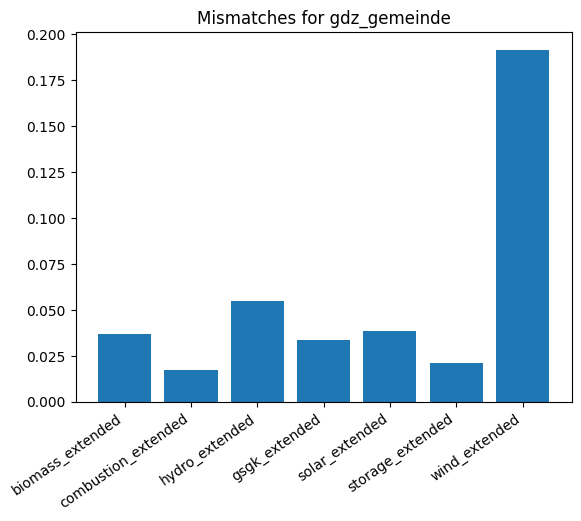

In [25]:
labels = list(share_mismatches.keys())
values = share_mismatches.values()
x = np.arange(len(labels))

plt.title(f"Mismatches for {BOUNDARY_FILE}")
plt.bar(x = x, height = values)
plt.xticks(ticks = x, labels = labels, rotation=35,  ha="right")
plt.show()